In [ ]:
!pip install skforecast

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np
import pandas as pd

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5
%matplotlib inline


# Modelado y Forecasting
# ==============================================================================
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

from skforecast.ForecasterAutoreg import ForecasterAutoreg
from lightgbm import LGBMRegressor # Es una implementación de grading boosting bastante avanzada, incluso para incluir nuevas variables
from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom
from skforecast.ForecasterAutoregDirect import ForecasterAutoregDirect
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster
from skforecast.utils import save_forecaster
from skforecast.utils import load_forecaster

In [ ]:
# Configuración warnings
# ==============================================================================
import warnings
# warnings.filterwarnings('ignore')

In [ ]:
file = ('https://raw.githubusercontent.com/JorgeMendiProject/TFM/main/DatasetInterpolado.csv')
#Lectura de datos a partir del archivo .csv             

dataset = pd.read_csv(file,delimiter=';')

dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 216 entries, 0 to 215
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Fecha          216 non-null    object 
 1   TasaTPIB       216 non-null    float64
 2   EuriborM       216 non-null    float64
 3   ParoT          216 non-null    float64
 4   SalarioMedio   216 non-null    int64  
 5   IPC            216 non-null    float64
 6   CTotalConsumo  216 non-null    int64  
dtypes: float64(4), int64(2), object(1)
memory usage: 11.9+ KB


In [ ]:
#Se convierte la variable Fecha a Datetime

dataset['Fecha'] = pd.to_datetime(dataset['Fecha'], format='%d/%m/%Y')

dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 216 entries, 0 to 215
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Fecha          216 non-null    datetime64[ns]
 1   TasaTPIB       216 non-null    float64       
 2   EuriborM       216 non-null    float64       
 3   ParoT          216 non-null    float64       
 4   SalarioMedio   216 non-null    int64         
 5   IPC            216 non-null    float64       
 6   CTotalConsumo  216 non-null    int64         
dtypes: datetime64[ns](1), float64(4), int64(2)
memory usage: 11.9 KB


In [ ]:
#Se adecua al formato que tiene el archivo base, es decir si hay meses se pone como meses para que no me queden Nan, si son días se pongo como días en el archivo inicial.
dataset = dataset.set_index('Fecha')
dataset = dataset.rename(columns={"Fecha":'x',"TasaTPIB":'y'})  
dataset = dataset.asfreq('M')
dataset = dataset.sort_index()
print(f'Número de filas con missing values: {dataset.isnull().any(axis=1).mean()}', '\n')

# Verificar que un índice temporal está completo
# ==============================================================================
(dataset.index == pd.date_range(
                    start = dataset.index.min(),
                    end   = dataset.index.max(),
                    freq  = dataset.index.freq)
).all()


Número de filas con missing values: 0.0 



True

Fechas train : 2002-01-31 00:00:00 --- 2018-12-31 00:00:00  (n=204)
Fechas test  : 2019-01-31 00:00:00 --- 2019-12-31 00:00:00  (n=12) 



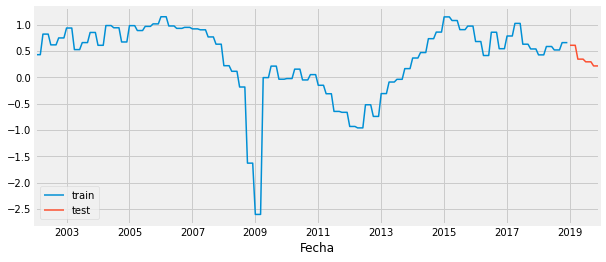

In [ ]:
# Separación datos train-test
# ==============================================================================
steps = 12
dataset_train = dataset[:-steps]
dataset_test  = dataset[-steps:]

print(f"Fechas train : {dataset_train.index.min()} --- {dataset_train.index.max()}  (n={len(dataset_train)})")
print(f"Fechas test  : {dataset_test.index.min()} --- {dataset_test.index.max()}  (n={len(dataset_test)})", '\n')

fig, ax = plt.subplots(figsize=(9, 4))
dataset_train['y'].plot(ax=ax, label='train')
dataset_test['y'].plot(ax=ax, label='test')
ax.legend();

In [ ]:
# LGBMRegressor
# Crear y entrenar forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                regressor = LGBMRegressor(max_depth=2, learning_rate=0.1, n_estimators=50),
                lags = 24
                )
forecaster.fit(y=dataset_train['y'])
forecaster

ForecasterAutoreg 
Regressor: LGBMRegressor(max_depth=2, n_estimators=50) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24] 
Transformer for y: None 
Transformer for exog: None 
Window size: 24 
Weight function included: False 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('2002-01-31 00:00:00'), Timestamp('2018-12-31 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: M 
Regressor parameters: {'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': 2, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 50, 'n_jobs': -1, 'num_leaves': 31, 'objective': None, 'random_state': None, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': True, 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0} 
Creation date: 2023-01-25 16:10:00 
Last fit 

In [ ]:
# Predicciones
# ==============================================================================
steps = 12
predicciones = forecaster.predict(steps=steps)
predicciones

2019-01-31    0.624951
2019-02-28    0.567219
2019-03-31    0.567219
2019-04-30    0.512639
2019-05-31    0.467925
2019-06-30    0.467925
2019-07-31    0.611009
2019-08-31    0.649819
2019-09-30    0.713455
2019-10-31    0.792621
2019-11-30    0.810640
2019-12-31    0.810640
Freq: M, Name: pred, dtype: float64

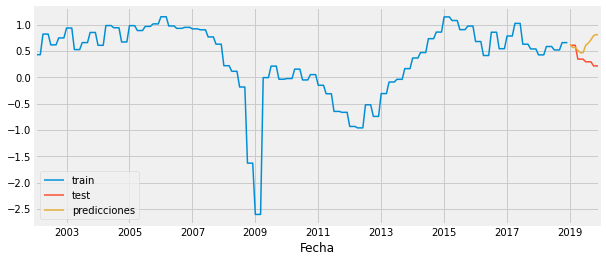

In [ ]:
# Gráfico Predicciones
# ==============================================================================
fig, ax = plt.subplots(figsize=(9, 4))
dataset_train['y'].plot(ax=ax, label='train')
dataset_test['y'].plot(ax=ax, label='test')
predicciones.plot(ax=ax, label='predicciones')
ax.legend();

In [ ]:
# Error test LGBM
# ==============================================================================
error_mse = mean_squared_error(
                y_true = dataset_test['y'],
                y_pred = predicciones
            )

print(f"Error de test (mse): {error_mse}", '\n')

Error de test (mse): 0.12480004587061257 



In [ ]:
# Grid search de hiperparámetros
# ==============================================================================
steps = 12
forecaster = ForecasterAutoreg(
                regressor = LGBMRegressor(max_depth=2, learning_rate=0.1, n_estimators=50),
                lags      = 24 # Este valor será remplazado en el grid search
             )

# Lags utilizados como predictores
lags_grid = [1, 48]

# Hiperparámetros del regresor
param_grid = {'n_estimators': [100, 500],
              'max_depth': [1, 3, 5, 10],
              'learning_rate':[0.1, 1] }

resultados_grid = grid_search_forecaster(
                        forecaster         = forecaster,
                        y                  = dataset_train['y'],
                        param_grid         = param_grid,
                        lags_grid          = lags_grid,
                        steps              = steps,
                        refit              = True,
                        metric             = 'mean_squared_error',
                        initial_train_size = int(len(dataset_train)*0.5),
                        fixed_train_size   = False,
                        return_best        = True,
                        verbose            = False
                  )

# Resultados Grid Search
# ==============================================================================
resultados_grid
print("los mejores resultados se dan: Usando una ventana temporal de 1 lag, y un LGBM de:(3 de profundidad y 500 estimadores)", '\n' "esto se ve en variable explorer: resultados grid")

Number of models compared: 32.


loop lags_grid: 100%|███████████████████████████████████████| 2/2 [00:15<00:00,  7.74s/it]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1] 
  Parameters: {'learning_rate': 1, 'max_depth': 1, 'n_estimators': 500}
  Backtesting metric: 0.1584157273466774

los mejores resultados se dan: Usando una ventana temporal de 1 lag, y un LGBM de:(3 de profundidad y 500 estimadores) 
esto se ve en variable explorer: resultados grid


In [ ]:
# Crear y entrenar forecaster con mejores hiperparámetros
# ==============================================================================
regressor = LGBMRegressor(max_depth=1, learning_rate=1, n_estimators=500)
forecaster = ForecasterAutoreg(
                regressor = regressor,
                lags      = 1
             )

forecaster.fit(y=dataset_train['y'])

2019-01-31    0.698950
2019-02-28    0.626681
2019-03-31    0.597510
2019-04-30    0.698109
2019-05-31    0.626681
2019-06-30    0.597510
2019-07-31    0.698109
2019-08-31    0.626681
2019-09-30    0.597510
2019-10-31    0.698109
2019-11-30    0.626681
2019-12-31    0.597510
Freq: M, Name: pred, dtype: float64
Error de test (mse) 0.09850408837155354


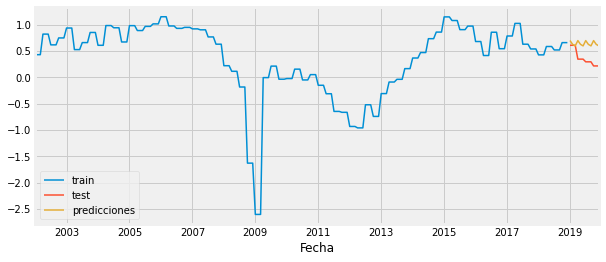

In [ ]:
# Predicciones
# ==============================================================================
predicciones = forecaster.predict(steps=steps)
print(predicciones)

# Gráfico
# ==============================================================================
fig, ax = plt.subplots(figsize=(9, 4))
dataset_train['y'].plot(ax=ax, label='train')
dataset_test['y'].plot(ax=ax, label='test')
predicciones.plot(ax=ax, label='predicciones')
ax.legend();


# Error de test
# ==============================================================================
error_mse = mean_squared_error(
                y_true = dataset_test['y'],
                y_pred = predicciones
            )

print(f"Error de test (mse) {error_mse}")

In [ ]:
# Backtesting
# ==============================================================================
steps = 3
n_backtesting = steps*4 #Se separan el útltimo año para el backtest
metrica, predicciones_backtest = backtesting_forecaster(
                                    forecaster         = forecaster,
                                    y                  = dataset['y'],
                                    initial_train_size = len(dataset) - n_backtesting,
                                    fixed_train_size   = False,
                                    steps              = steps,
                                    refit              = True,
                                    metric             = 'mean_squared_error',
                                    verbose            = True
                                 )

print(f"Error de backtest: {metrica}",'\n')
predicciones_backtest


Information of backtesting process
----------------------------------
Number of observations used for initial training: 204
Number of observations used for backtesting: 12
    Number of folds: 4
    Number of steps per fold: 3

Data partition in fold: 0
    Training:   2002-01-31 00:00:00 -- 2018-12-31 00:00:00  (n=204)
    Validation: 2019-01-31 00:00:00 -- 2019-03-31 00:00:00  (n=3)
Data partition in fold: 1
    Training:   2002-01-31 00:00:00 -- 2019-03-31 00:00:00  (n=207)
    Validation: 2019-04-30 00:00:00 -- 2019-06-30 00:00:00  (n=3)
Data partition in fold: 2
    Training:   2002-01-31 00:00:00 -- 2019-06-30 00:00:00  (n=210)
    Validation: 2019-07-31 00:00:00 -- 2019-09-30 00:00:00  (n=3)
Data partition in fold: 3
    Training:   2002-01-31 00:00:00 -- 2019-09-30 00:00:00  (n=213)
    Validation: 2019-10-31 00:00:00 -- 2019-12-31 00:00:00  (n=3)

Error de backtest: 0.018634511892910235 



,pred
2019-01-31,0.698950
2019-02-28,0.626681
2019-03-31,0.597510
2019-04-30,0.638129
2019-05-31,0.525298
2019-06-30,0.562137
2019-07-31,0.379922
2019-08-31,0.379922
2019-09-30,0.379922
2019-10-31,0.316112


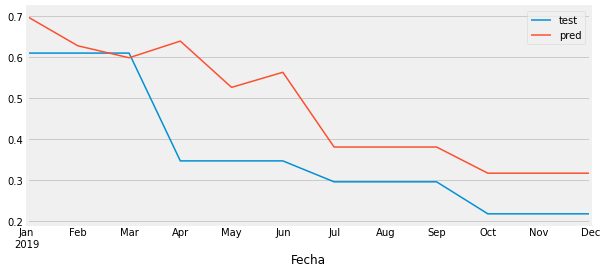

In [ ]:
# Gráfico del Backtesting
# ========================
fig, ax = plt.subplots(figsize=(9, 4))
dataset_test['y'].plot(ax=ax, label='test')
predicciones_backtest.plot(ax=ax, label='predicciones_backtest')
ax.legend();


In [ ]:
# Importancia predictores
# ==============================================================================
impotancia = forecaster.get_feature_importance()
impotancia

,feature,importance
0,lag_1,500


In [ ]:
# Crear y entrenar forecaster con mejores hiperparámetros
# ==============================================================================
regressor = LGBMRegressor(max_depth=1, learning_rate=1, n_estimators=500)
forecaster = ForecasterAutoreg(
                regressor = regressor,
                lags      = 1
             )


"\nforecaster.fit(y=dataset_train['y'])\n"

In [ ]:
# Se añaden las variables exógenas y se reentrena el modelo
# =============================================================================

variables_exog = ['EuriborM', 'ParoT', 'SalarioMedio', 'IPC','CTotalConsumo']
fin_train = '31/12/2018'
forecaster.fit(
    y= dataset.loc[:fin_train:,'y'],
    exog= dataset.loc[:fin_train:, variables_exog]
    ) # Entrenamiento con conjuntos de train
forecaster

ForecasterAutoreg 
Regressor: LGBMRegressor(learning_rate=1, max_depth=1, n_estimators=500) 
Lags: [1] 
Transformer for y: None 
Transformer for exog: None 
Window size: 1 
Weight function included: False 
Exogenous included: True 
Type of exogenous variable: <class 'pandas.core.frame.DataFrame'> 
Exogenous variables names: ['EuriborM', 'ParoT', 'SalarioMedio', 'IPC', 'CTotalConsumo'] 
Training range: [Timestamp('2002-01-31 00:00:00'), Timestamp('2018-12-31 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: M 
Regressor parameters: {'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 1, 'max_depth': 1, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 500, 'n_jobs': -1, 'num_leaves': 31, 'objective': None, 'random_state': None, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': True, 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0} 
Creation d

In [ ]:
exog_siguientes_12meses = dataset_test[variables_exog][:12]

predicciones = forecaster.predict(steps=12, exog=exog_siguientes_12meses)
predicciones

2019-01-31    0.605688
2019-02-28    0.560929
2019-03-31    0.551848
2019-04-30    0.588070
2019-05-31    0.551848
2019-06-30    0.572890
2019-07-31    0.528541
2019-08-31    0.566523
2019-09-30    0.572890
2019-10-31    0.588070
2019-11-30    0.551848
2019-12-31    0.572890
Freq: M, Name: pred, dtype: float64

In [ ]:
# Backtesting
# ==============================================================================
steps = 3
n_backtesting = steps*4 #Se separan el útltimo año para el backtest
metrica, predicciones_backtest = backtesting_forecaster(
                                    forecaster         = forecaster,
                                    y                  = dataset['y'],
                                    exog               = dataset[variables_exog],
                                    initial_train_size = len(dataset) - n_backtesting,
                                    fixed_train_size   = False,
                                    steps              = steps,
                                    refit              = True,
                                    metric             = 'mean_squared_error',
                                    verbose            = True
                                 )

print(f"Error de backtest: {metrica}",'\n')
predicciones_backtest

Information of backtesting process
----------------------------------
Number of observations used for initial training: 204
Number of observations used for backtesting: 12
    Number of folds: 4
    Number of steps per fold: 3

Data partition in fold: 0
    Training:   2002-01-31 00:00:00 -- 2018-12-31 00:00:00  (n=204)
    Validation: 2019-01-31 00:00:00 -- 2019-03-31 00:00:00  (n=3)
Data partition in fold: 1
    Training:   2002-01-31 00:00:00 -- 2019-03-31 00:00:00  (n=207)
    Validation: 2019-04-30 00:00:00 -- 2019-06-30 00:00:00  (n=3)
Data partition in fold: 2
    Training:   2002-01-31 00:00:00 -- 2019-06-30 00:00:00  (n=210)
    Validation: 2019-07-31 00:00:00 -- 2019-09-30 00:00:00  (n=3)
Data partition in fold: 3
    Training:   2002-01-31 00:00:00 -- 2019-09-30 00:00:00  (n=213)
    Validation: 2019-10-31 00:00:00 -- 2019-12-31 00:00:00  (n=3)

Error de backtest: 0.013360889861306667 



,pred
2019-01-31,0.605688
2019-02-28,0.560929
2019-03-31,0.551848
2019-04-30,0.541493
2019-05-31,0.547176
2019-06-30,0.571748
2019-07-31,0.312272
2019-08-31,0.352435
2019-09-30,0.352435
2019-10-31,0.307091


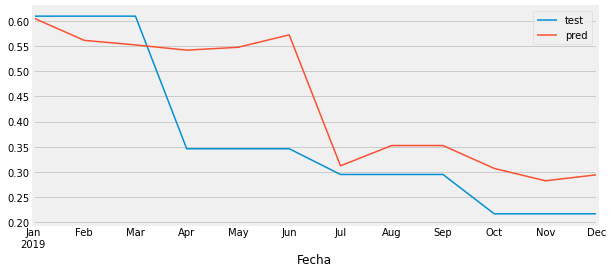

In [ ]:
# Gráfico del Backtesting
# ========================
fig, ax = plt.subplots(figsize=(9, 4))
dataset_test['y'].plot(ax=ax, label='test')
predicciones_backtest.plot(ax=ax, label='predicciones_backtest')
ax.legend();